In [9]:
import numpy as np
import xarray as xr
import sys
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap

Dir = '/n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/'
figDir = Dir + 'figure/'

sys.path.append(Dir + 'imi-gchp-local')

from src.inversion_scripts.utils import (
    plot_field,
    plot_field_gchp,
    load_obj,
    sum_total_emissions,
    count_obs_in_mask,
    get_posterior_emissions,
    get_mean_emissions,
    plot_ensemble,
    plot_hyperparameter_analysis,
)

In [6]:
# emisfpath = '/n/holylfs06/LABS/jacob_lab/Shared/GEOS-CHEM/gcgrid/gcdata/ExtData/\
# HEMCO/CH4/v2025-07/HEMCO_SA_Output/HEMCO_sa_diagnostics.0125x015625.2023.nc'
emisfpath = '/n/holylfs06/LABS/jacob_lab/Shared/GEOS-CHEM/gcgrid/gcdata/ExtData/\
HEMCO/CH4/v2025-07/HEMCO_SA_Output/HEMCO_sa_diagnostics.025x03125.2023.nc'
# emisfpath = '/n/holylfs06/LABS/jacob_lab/Shared/GEOS-CHEM/gcgrid/gcdata/ExtData/\
# HEMCO/CH4/v2025-07/HEMCO_SA_Output/HEMCO_sa_diagnostics.2x25.2023.nc'
emisds = xr.open_dataset(emisfpath).squeeze()

emis = emisds['EmisCH4_Total'].values - emisds['EmisCH4_SoilAbsorb'].values
soilsink = emisds['EmisCH4_SoilAbsorb'].values * -1
netflux = emisds['EmisCH4_Total'].values
unit_convert = 1e-9 * 24 * 3600 * 365 # convert kg/s to Tg/yr

Threshold emission flux for 99.9% of total emissions: 1.1038904165761032e-12
Threshold emission flux for 99.0% of total emissions: 8.757570189865671e-12
Threshold emission flux for 98.0% of total emissions: 1.6795174626049736e-11


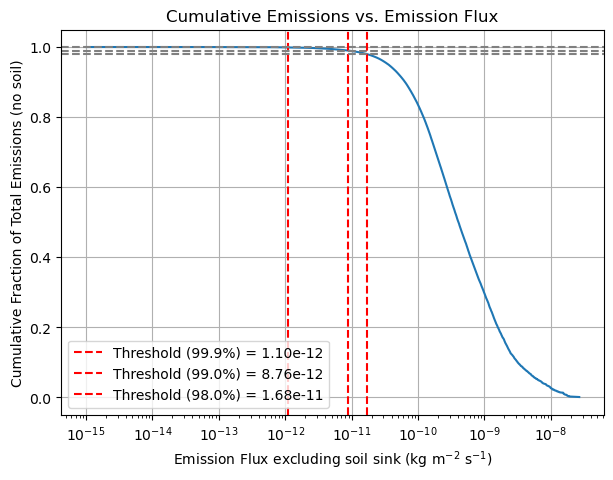

In [7]:
# threshold for emissions excluding soil sink
ind = np.where(emis>1e-15)
emission_flux = emis[ind]  # units: e.g., kg/m²/s
area = emisds['AREA'].values[ind]            # units: m²

# Step 1: Calculate total emissions for each grid cell
emissions = emission_flux * area * unit_convert

# Step 2: Sort by emission flux in descending order (important!)
sorted_indices = np.argsort(emission_flux)[::-1]
sorted_flux = emission_flux[sorted_indices]
sorted_emissions = emissions[sorted_indices]

# Step 3: Compute cumulative emissions
cumulative_emissions = np.cumsum(sorted_emissions)

# Step 4: Total emissions
total_emissions = cumulative_emissions[-1]
cumulative_fraction = cumulative_emissions / total_emissions

# Step 5: Find the threshold flux for 99.9% of total emissions
threshold_fraction = np.array([0.999, 0.99, 0.98])
idx = np.searchsorted(cumulative_emissions, threshold_fraction * total_emissions)
threshold_flux = sorted_flux[idx]

plt.figure(figsize=(7,5))
plt.plot(sorted_flux, cumulative_fraction)

for frac, flux in zip(threshold_fraction, threshold_flux):
    print(f"Threshold emission flux for {frac*100:.1f}% of total emissions: {flux}")
    plt.axvline(flux, color='red', linestyle='--', label=f"Threshold ({frac*100:.1f}%) = {flux:.2e}")
    plt.axhline(frac, color='gray', linestyle='--')

# Labels & title
plt.xscale('log')
plt.xlabel("Emission Flux excluding soil sink " + r"$\rm (kg\ m^{-2}\ s^{-1})$")
plt.ylabel("Cumulative Fraction of Total Emissions (no soil)")
plt.title("Cumulative Emissions vs. Emission Flux")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
def get_statevector_gchp(sv_gchp_fpath):
    sv_gchp_ds = xr.open_dataset(sv_gchp_fpath).squeeze()
    sv_gchp = sv_gchp_ds['StateVector'].values
    sv_mask_gchp = sv_gchp <= np.nanmax(sv_gchp)

    corner_lons = sv_gchp_ds['corner_lons'].values
    corner_lats = sv_gchp_ds['corner_lats'].values
    res = len(sv_gchp_ds.Xdim)

    all_corners_gchp = []
    all_sv_gchp = []

    for face in range(6):  
        corner_lonsi = corner_lons[face]  
        corner_latsi = corner_lats[face]
        c = np.stack((corner_lonsi, corner_latsi), axis=-1) 
        
        # Construct 5-point polygons for all cells
        face_corners = np.stack([
            c[:-1, :-1],
            c[1:, :-1],
            c[1:, 1:],
            c[:-1, 1:],
            c[:-1, :-1]
        ], axis=2)
        face_corners = face_corners.reshape((res * res, 5, 2))
        face_corners = face_corners.tolist()
        
        all_corners_gchp.append(face_corners)
        all_sv_gchp.append(sv_gchp[face].ravel())

    all_corners_gchp = np.concatenate(all_corners_gchp)
    all_sv_gchp = np.concatenate(all_sv_gchp)

    valid_corners_gchp = all_corners_gchp[sv_mask_gchp.ravel(),...]
    valid_sv_gchp = all_sv_gchp[sv_mask_gchp.ravel(),...]

    return valid_corners_gchp, valid_sv_gchp

In [3]:
def plot_statevector_gchp(valid_corners_gchp, valid_sv_gchp, emis_frac, res, extents=[-180,180,-60,88]):
    aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
    proj = ccrs.PlateCarree()
    trans = ccrs.Geodetic()

    totwidth = 6.5
    nrows, ncols = 1, 1
    subwidth = totwidth / ncols
    subheight = subwidth / aspect
    totheight = subheight * nrows

    fig, ax = plt.subplots(
        nrows, ncols,
        figsize=(totwidth, totheight),
        subplot_kw={'projection': proj},
        constrained_layout=True
    )
    if emis_frac=='':
        axtitle = f'State vector: GCHP C{res}'
    else:
        axtitle = f'State vector: GCHP C{res} ({emis_frac*100:.1f}%)'
    ax.set_title(axtitle)
    ax.set_extent(extents, crs=proj)
    ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '110m', \
        edgecolor='black', facecolor='none', linewidth=.5))
    ax.add_feature(cfeat.BORDERS, linewidth=.1)
    if emis_frac=='':
        ax.text(0.88, 0.05, f'Number of elements: {valid_sv_gchp.shape[0]}',
            transform=ax.transAxes, ha='right', fontsize=10)
    else:
        if res=='360':
            ax.text(0.88, 0.05, f'Number of elements: {valid_sv_gchp.shape[0]}' + '\n' + \
                f'Ratio of # of elements: {valid_sv_gchp.shape[0]/242112:.2f}',
                transform=ax.transAxes, ha='right', fontsize=10)
        else:
            ax.text(0.88, 0.05, f'Number of elements: {valid_sv_gchp.shape[0]}' + '\n' + \
                f'Ratio of # of elements: {valid_sv_gchp.shape[0]/4711:.2f}',
                transform=ax.transAxes, ha='right', fontsize=10)
    
    coll = PolyCollection(
        valid_corners_gchp, lw=0.3, edgecolors='red',facecolors='none',
        transform=trans,
    )
    ax.add_collection(coll)
    # figfpath = figDir + 'GCHP-GCC_statevector.png'
    # fig.savefig(figfpath, format="png", bbox_inches="tight", dpi=300)
    # print(f"Plot saved to {figfpath}")
    # plt.close()

In [11]:
def save_sv_background_png(valid_corners_gchp, valid_sv_gchp, res,
                           extents=(-180,180,-60,88),
                           png_path="sv_bg.png", dpi=300, make_dirs=True,
                           draw_land=True, draw_ocean=True, draw_coast=True, draw_borders=True):
    """
    Save an opaque PlateCarree PNG *exactly* covering `extents`.
    The output is a rectangle with aspect = (Δlon)/(Δlat), no extra padding.
    """
    if make_dirs:
        os.makedirs(os.path.dirname(png_path) or ".", exist_ok=True)

    lon0, lon1, lat0, lat1 = extents
    aspect = (lon1 - lon0) / (lat1 - lat0)

    # Choose figure size that matches the aspect precisely
    fig_w = 2000 / dpi  # ~2000 px wide output (adjust as you like)
    fig_h = fig_w / aspect

    proj = ccrs.PlateCarree()
    trans = ccrs.Geodetic()

    fig = plt.figure(figsize=(fig_w, fig_h), dpi=dpi)
    ax = plt.axes(projection=proj)

    # Make the map area fill the entire figure (no padding/margins)
    ax.set_position([0, 0, 1, 1])
    ax.set_extent(extents, crs=proj)

    # Optional fills baked into the PNG
    if draw_ocean:
        ax.add_feature(cfeat.OCEAN.with_scale('110m'), facecolor='#f0f0f0', edgecolor='none', zorder=0)
    if draw_land:
        ax.add_feature(cfeat.LAND.with_scale('110m'),  facecolor='#bdbdbd', edgecolor='none', zorder=1)
    if draw_coast:
        ax.add_feature(cfeat.COASTLINE.with_scale('110m'), linewidth=0.3, edgecolor='black', zorder=2)
    if draw_borders:
        ax.add_feature(cfeat.BORDERS.with_scale('110m'),   linewidth=0.2, edgecolor='black', zorder=2)

    # Your SV outlines, clipped to map boundary
    coll = PolyCollection(valid_corners_gchp, lw=0.3, edgecolors='red', facecolors='none',
                          transform=trans, zorder=3, clip_on=True)
    ax.add_collection(coll)

    # Remove all axes ornaments
    ax.set_xticks([]); ax.set_yticks([])
    try:
        ax.spines['geo'].set_visible(False)
    except Exception:
        pass
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='black', alpha=0.5)
    # IMPORTANT: do NOT use bbox_inches='tight' here
    fig.savefig(png_path, transparent=False, facecolor='white', bbox_inches=None, pad_inches=0)
    plt.close(fig)
    print(png_path)


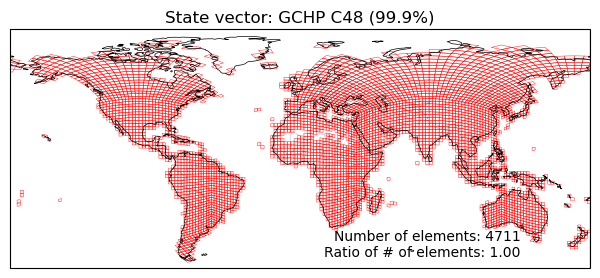

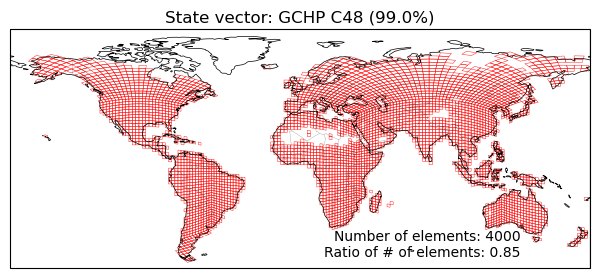

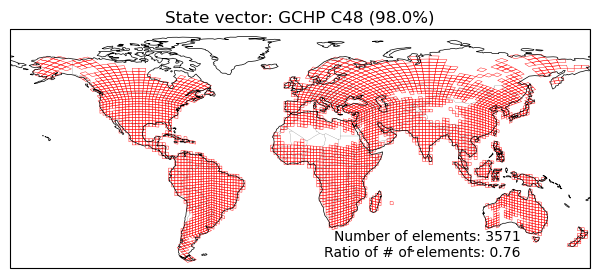

In [ ]:
sv_dir = f'{Dir}output-gchp-local-soil/Test_Global_1month/'
emis_thres = np.array(['1.10e-12', '8.76e-12', '1.68e-11'])
emis_frac = np.array([0.999, 0.99, 0.98])
res = '48'
for i in range(len(emis_frac)):
    sv_fpath = f'{sv_dir}StateVector.{emis_thres[i]}.nc'
    valid_corners_gchp, valid_sv_gchp = get_statevector_gchp(sv_fpath)
    plot_statevector_gchp(valid_corners_gchp, valid_sv_gchp, emis_frac[i], res, extents=[-180,180,-60,88])

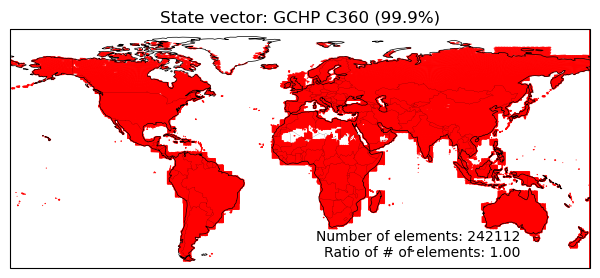

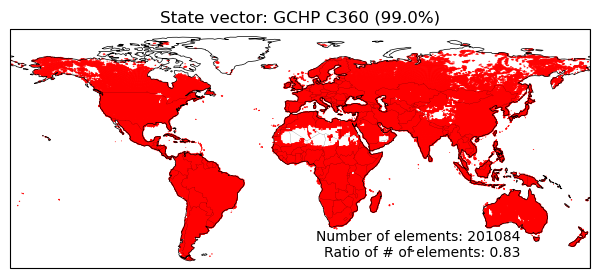

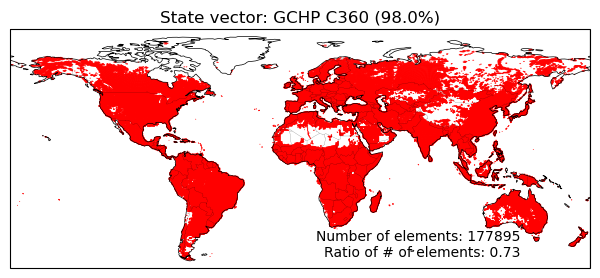

In [5]:
sv_dir = f'{Dir}output-gchp-local-soil/Test_Global_1month_c360/'
emis_thres = np.array(['1.10e-12', '8.76e-12', '1.68e-11'])
emis_frac = np.array([0.999, 0.99, 0.98])
res = '360'
for i in range(len(emis_frac)):
    sv_fpath = f'{sv_dir}StateVector.{emis_thres[i]}.nc'
    valid_corners_gchp, valid_sv_gchp = get_statevector_gchp(sv_fpath)
    plot_statevector_gchp(valid_corners_gchp, valid_sv_gchp, emis_frac[i], res, extents=[-180,180,-60,88])
    save_sv_background_png(valid_corners_gchp, valid_sv_gchp, res,
                        extents=(-180,180,-60,88),
                        png_path=f"{figDir}sv_bg_c{res}_emis-{emis_frac[i]}.png", dpi=300)

In [13]:
save_sv_background_png(valid_corners_gchp, valid_sv_gchp, res,
                        extents=(-180,180,-90,90),
                        png_path=f"{figDir}sv_bg_c{res}_emis-{emis_frac[i]}.png", dpi=300)

/n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/figure/sv_bg_c360_emis-0.98.png


Threshold emission flux for 99.9% of soil sink: 5.630435896165908e-13


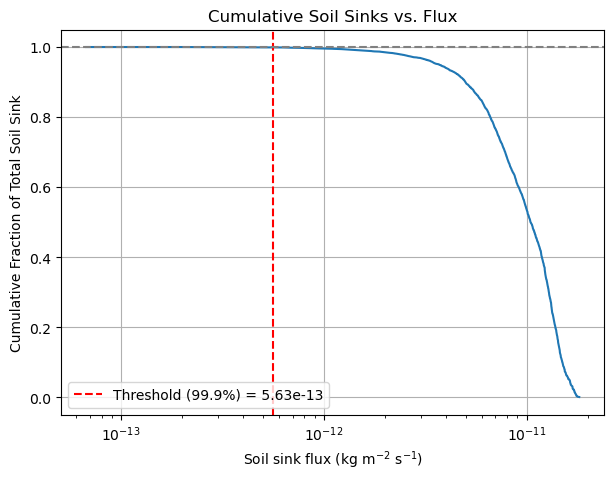

In [85]:
# threshold for soil sink
ind = np.where(soilsink>1e-15)
emission_flux = soilsink[ind]  # units: e.g., kg/m²/s
area = emisds['AREA'].values[ind]            # units: m²

# Step 1: Calculate total emissions for each grid cell
emissions = emission_flux * area * unit_convert

# Step 2: Sort by emission flux in descending order (important!)
sorted_indices = np.argsort(emission_flux)[::-1]
sorted_flux = emission_flux[sorted_indices]
sorted_emissions = emissions[sorted_indices]

# Step 3: Compute cumulative emissions
cumulative_emissions = np.cumsum(sorted_emissions)

# Step 4: Total emissions
total_emissions = cumulative_emissions[-1]
cumulative_fraction = cumulative_emissions / total_emissions

# Step 5: Find the threshold flux for 99.9% of total emissions
threshold_fraction = 0.999
idx = np.searchsorted(cumulative_emissions, threshold_fraction * total_emissions)
threshold_flux = sorted_flux[idx]

print(f"Threshold emission flux for 99.9% of soil sink: {threshold_flux}")

plt.figure(figsize=(7,5))
plt.plot(sorted_flux, cumulative_fraction)
plt.axvline(threshold_flux, color='red', linestyle='--', label=f"Threshold (99.9%) = {threshold_flux:.2e}")
plt.axhline(threshold_fraction, color='gray', linestyle='--')

# Labels & title
plt.xscale('log')
plt.xlabel("Soil sink flux " + r"$\rm (kg\ m^{-2}\ s^{-1})$")
plt.ylabel("Cumulative Fraction of Total Soil Sink")
plt.title("Cumulative Soil Sinks vs. Flux")
plt.legend()
plt.grid(True)
plt.show()

In [95]:
# Plot state vector for emission only with threshold of 1e-12
sv_gcc_fpath = '/n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/\
output-gcc-global/Test_Global_1day/StateVector.nc'
sv_gcc_ds = xr.open_dataset(sv_gcc_fpath).squeeze()
sv_gcc = sv_gcc_ds['StateVector'].values
sv_mask_gcc = sv_gcc <= np.nanmax(sv_gcc)

lat = sv_gcc_ds['lat'].values
lon = sv_gcc_ds['lon'].values
gcc_gridfpath = Dir + 'supportData/regular_lat_lon_75x144.nc'
gcc_gridds = xr.open_dataset(gcc_gridfpath)
lat_bnds = gcc_gridds['lat_bnds'].values
lon_bnds = gcc_gridds['lon_bnds'].values
lon_bnds[lon_bnds>180] -= 360

all_corners_gcc = []
all_sv_gcc = []

nlat, nlon = sv_gcc.shape

for i in range(nlat):
    lat_min, lat_max = lat_bnds[i]
    for j in range(nlon):
        lon_min, lon_max = lon_bnds[j]
        
        # 5-point polygon (counter-clockwise, closed)
        polygon = [
            [lon_min, lat_min],  # lower-left
            [lon_max, lat_min],  # lower-right
            [lon_max, lat_max],  # upper-right
            [lon_min, lat_max],  # upper-left
            [lon_min, lat_min],  # close polygon
        ]
        
        all_corners_gcc.append(polygon)
        all_sv_gcc.append(sv_gcc[i, j])

all_corners_gcc = np.array(all_corners_gcc)  # shape: (lat*lon, 5, 2)
all_sv_gcc = np.array(all_sv_gcc)            # shape: (lat*lon,)
valid_corners_gcc = all_corners_gcc[sv_mask_gcc.ravel(),...]
valid_sv_gcc = all_sv_gcc[sv_mask_gcc.ravel(),...]

Plot saved to /n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/figure/GCC_statevector_emis-soil_5.6e-12.png


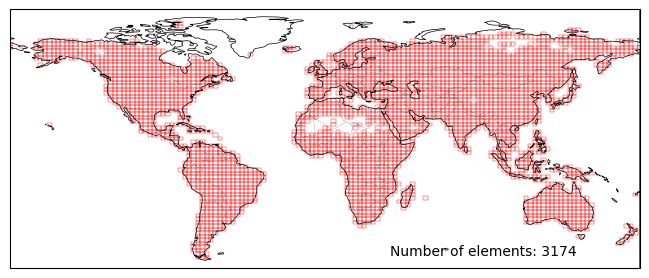

In [96]:
extents = [-180, 180, -60, 88]
# extents = [-60, -10, 58, 88]
aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
proj = ccrs.PlateCarree()
trans = ccrs.Geodetic()

totwidth = 6.5
nrows, ncols = 1, 1
subwidth = totwidth / ncols
subheight = subwidth / aspect
totheight = subheight * nrows

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(totwidth, totheight),
    subplot_kw={'projection': proj},
    constrained_layout=True
)

axtitles = ['State vector: GCC ' + r'$\rm 2 ^{\circ} \times 2.5 ^{\circ}$']
for rowi in range(nrows):
    # ax = axes.flat[rowi]
    ax = axes
    
    ax.set_extent(extents, crs=proj)
    ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '110m', \
        edgecolor='black', facecolor='none', linewidth=.5))
    ax.add_feature(cfeat.BORDERS, linewidth=.1)
    ax.text(0.9, 0.05, f'Number of elements: {valid_sv_gcc.shape[0]}',
        transform=ax.transAxes, ha='right', fontsize=10)
    
    coll = PolyCollection(
        valid_corners_gcc, lw=0.3, edgecolors='red',facecolors='none',
        transform=trans,
    )
    ax.add_collection(coll)
    
# plt.show()
figfpath = figDir + 'GCC_statevector_emis-soil_5.6e-12.png'
fig.savefig(figfpath, format="png", bbox_inches="tight", dpi=300)
print(f"Plot saved to {figfpath}")

In [88]:
# create colormap
N = 20
top = ListedColormap(mpl.colormaps['turbo'](np.linspace(0.1, 1., 256-N)))
edgecolor = mpl.colormaps['turbo'](np.linspace(0.1, 1., 256-N))[0,:]
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1,edgecolor[0], N)
vals[:, 1] = np.linspace(1,edgecolor[1], N)
vals[:, 2] = np.linspace(1,edgecolor[2], N)
bottom = ListedColormap(vals)
newcolors = np.vstack((bottom(np.linspace(0, 1, N)), top(np.linspace(0, 1, 256-N))))
newcmp = ListedColormap(newcolors, name='Whturbo')
newcmp_r = newcmp.reversed()
mpl.colormaps.register(cmap=newcmp, force=True)
mpl.colormaps.register(cmap=newcmp_r, force=True)

/tmp/ipykernel_3803855/3213718576.py:13: UserWarning: Overwriting the cmap 'Whturbo' that was already in the registry.
  mpl.colormaps.register(cmap=newcmp, force=True)
/tmp/ipykernel_3803855/3213718576.py:14: UserWarning: Overwriting the cmap 'Whturbo_r' that was already in the registry.
  mpl.colormaps.register(cmap=newcmp_r, force=True)


Max: 5.601e-12
Plot saved to /n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/figure/HEMCO_2x25_prior_emissions_2023.png


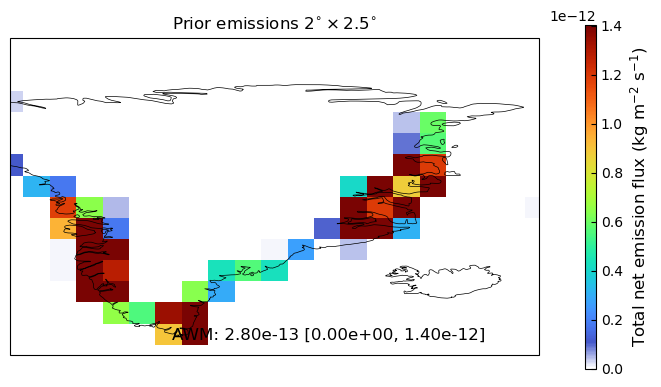

In [100]:
# plot emissions over Greenland
lat = emisds['lat'].values
lon = emisds['lon'].values
lonm, latm = np.meshgrid(lon, lat)
prior = np.array(emisds['EmisCH4_Total'].values - 2* emisds['EmisCH4_SoilAbsorb'].values)
# prior = np.array(netflux)

area = emisds['AREA'].values
label = 'Total net emission flux ' + r'$\rm (kg\ m^{-2}\ s^{-1})$'

cmap = 'Whturbo'
extents = [-60, -10, 58, 88]
extents_ice = [-30, -10, 58, 67]

ind = np.where((lonm>=extents[0]) & (lonm<=extents[1]) & (latm>=extents[2]) & (latm<=extents[3]) & \
    ~(lonm>=extents_ice[0]) & (lonm<=extents_ice[1]) & (latm>=extents_ice[2]) & (latm<=extents_ice[3]))

in_region = ((lonm >= extents[0]) & (lonm <= extents[1]) &
             (latm >= extents[2]) & (latm <= extents[3]))

in_ice = ((lonm >= extents_ice[0]) & (lonm <= extents_ice[1]) &
          (latm >= extents_ice[2]) & (latm <= extents_ice[3]))

# Final mask: in main region AND NOT in ice region
mask = in_region & ~in_ice

vmin = np.nanpercentile(prior[mask], 5)
vmax = np.nanpercentile(prior[mask], 95)
# vmax = 1e-12
print('Max: {:.3e}'.format(prior[mask].max()))
prior[~mask] = np.nan

aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
proj = ccrs.PlateCarree()
trans = ccrs.PlateCarree()

totwidth = 6.5
nrows, ncols = 1, 1
subwidth = totwidth / ncols
subheight = subwidth / aspect
totheight = subheight * nrows

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(totwidth, totheight),
    subplot_kw={'projection': proj},
    constrained_layout=True
)


axtitles = ['Prior emissions ' + r"$\rm 2^{\circ} \times 2.5^{\circ}$"]
for rowi in range(nrows):
    ax = axes
    
    ax.set_title(axtitles[rowi], fontsize=12)
    ax.set_extent(extents, crs=proj)
    ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '50m', \
        edgecolor='black', facecolor='none', linewidth=.5))
    ax.add_feature(cfeat.BORDERS, linewidth=.1)
    
    pcm = ax.pcolormesh(
        lon, lat, prior,
        transform=trans,
        cmap=cmap, shading='auto',
        vmin=vmin, vmax=vmax
    )
    
    AWM = np.nansum(prior[mask] * area[mask]) / np.nansum(area[mask])
    mean = np.nanmean(prior[mask])
    lower = np.nanpercentile(prior[mask], 5)
    upper = np.nanpercentile(prior[mask], 95)
    ax.text(0.9, 0.05, 'AWM: {:.2e} '.format(AWM) + '[{:.2e}, {:.2e}]'.format(lower, upper),
            transform=ax.transAxes, ha='right', fontsize=12)
cbar = fig.colorbar(pcm, ax=axes, orientation='vertical', 
                    aspect=30, shrink=0.9, pad=0.02)
cbar.set_label(label, fontsize=12)
cbar.ax.minorticks_off()
cbar.ax.tick_params(axis='y', which='major', labelsize=10, direction='in')
figfpath = figDir + 'HEMCO_2x25_prior_emissions_2023.png'
fig.savefig(figfpath, format="png", bbox_inches="tight", dpi=300)
print(f"Plot saved to {figfpath}")
# plt.close()

Plot saved to /n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/figure/GCC_Sectoral_emissions_Greenland.png


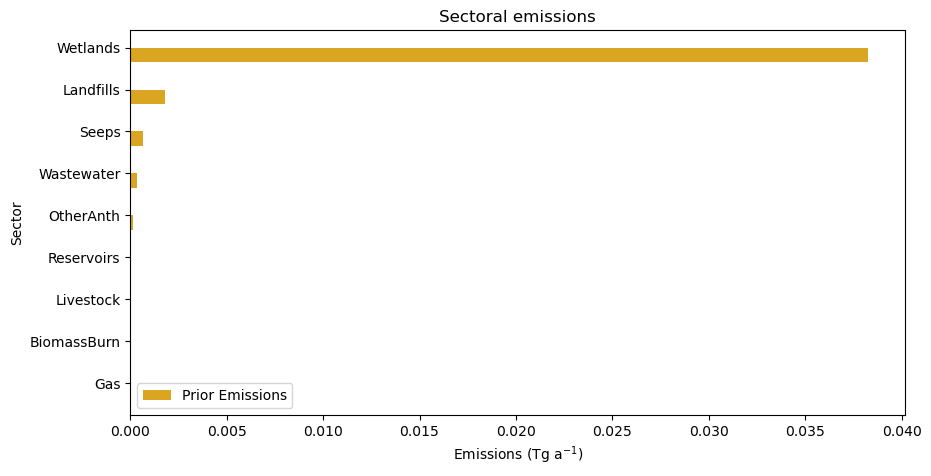

In [91]:
# Plot sectoral contributions in Greenland
# sectoral contributions
# Extract sector names
sectors = [
    var
    for var in list(emisds.keys())
    if "EmisCH4" in var and not ("Total" in var or "Excl" in var)
]

# Calculate total emissions for each sector
prior_sector_vals_gcc = []
sectors_gcc = []
for sector in sectors:
    prior_val_gcc = sum_total_emissions(emisds[sector], emisds['AREA'], mask)
    if abs(prior_val_gcc) > 0:
        prior_sector_vals_gcc.append(prior_val_gcc)
        sectors_gcc.append(sector.replace("EmisCH4_", ""))

# Combine the lists into tuples and sort them based on post_sector_vals
combined = list(zip(sectors_gcc, prior_sector_vals_gcc))
combined_sorted = sorted(combined, key=lambda x: x[1])
sectors, prior_sector_vals = zip(*combined_sorted)

# Plot bars for prior and posterior
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1, 1)
bar_height = 0.35
ind = np.arange(len(sectors))

bars1 = ax.barh(
    ind - bar_height / 2,
    prior_sector_vals,
    bar_height,
    color="goldenrod",
    label="Prior Emissions",
)

# Add labels, title, and legend
ax.set_xlabel(r"$\rm Emissions\ ( Tg\ a^{-1})$")
ax.set_ylabel("Sector")
ax.set_title("Sectoral emissions")
ax.set_yticks(ind)
ax.set_yticklabels(sectors)
ax.legend()

figfpath = figDir + 'GCC_Sectoral_emissions_Greenland.png'
plt.savefig(figfpath, bbox_inches="tight")
print(f"Plot saved to {figfpath}")
# plt.close()